In [1]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene
import satpy

In [2]:
# Works for MODIS and S3 .L2.OC.x.nc files #
#  Test for MERIS
#files = glob('/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/SEP2010/AQUA_MODIS.*.L2.OC.x.nc')
files = glob('../../SAT_DATA/NC/GOM21FA_MODIS_Level-2/AQUA_MODIS.*.L2.OC.x.nc')
files

['../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T180001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T180501.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T194001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T184500.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202000.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202500.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T192501.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T193001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183501.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T201001.L2.OC.x.nc',
 '../../SAT_DATA/NC/GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211028T191500.L2.OC.x.nc',
 '..

# OPENING FILES, PUTING THEM IN A COMMON GRID, AND SAVING A COMBINED FILE

In [5]:
# Functions to be used

def convtoxr(scn, var):
    #convert from dask array
    data = scn[var].load()
    data.name = var
    del(data.attrs['_satpy_id']) ### removing, we don't need this.
    data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
    return data

def load_satdata(path, 
                 area_deff=None,
                 res=None,
                 name="GOMEX", proj={"proj": "laea"}, area_extent=(-91, 28, -88, 31),
                ):
#   get data and attributes
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    attrs = xr.open_dataset(path).attrs
    
#   area definition if not defined
    if res is None:
        # get the resolution of the Sat product
        val, unit = attrs['spatialResolution'].split()
        res  = xr.DataArray(float(val), attrs={"units": unit})
    if area_deff is None:
        area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)
        
#   reprojecting
    scn = Scene()
    swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
    vnames = [v for v in data.data_vars if 'Rrs' in v]
    for var in vnames:
        scn[var] = data[var]
        scn[var].attrs["area"] = swath_def
    resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
    resampled_scn.compute()
    lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
    
#   Converting back to xarray dataset
    ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
    ds.attrs = attrs
    ds = ds.assign_coords({
                            'lon': (('y', 'x'), lons),
                            'lat': (('y', 'x'), lats),
                            'time': pd.to_datetime(attrs['time_coverage_start'])
                            })
#   getting rid of the crs coord
    # ds.attrs['crs'] = ds.crs
    ds = ds.drop('crs')
    print(str(ds.time.data))
    return ds

In [6]:
# Area setup for GOMEX
resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
extent = (-91, 28, -88, 31)
res = xr.DataArray(resval, attrs={"units": "meters"})
lat_0, lon_0 = 28.5, -90.8 # just some rounded up mean from the lat lon range of the sat product
proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
area = create_area_def("GOMEX", proj,
                       area_extent=extent, units="degrees", 
                       resolution=res
                      ) # creating a fixed area to reproject to

# Reprojectig files
dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
combined = xr.concat(dsets, dim='time') #combining in one file


#for naming the file
date = [f.split('.')[1] for f in files]
year = ((date[1])[0:4])
month = ((date[1])[4:6])

#save combined file
# give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite
combined.to_netcdf('../../SAT_DATA/NC/' + year + '_' + month + '_MODIS_L2.nc') 



Rounding shape to (1123, 956) and resolution from (300.0, 300.0) meters to (299.72703443568895, 299.85149942752383) meters
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another 

2021-10-24T18:00:01.353000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-24T18:05:01.207000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-24T19:40:01.385000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-25T18:45:00.793000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-25T20:20:00.972000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-25T20:25:00.826000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-26T19:25:01.858000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-26T19:30:01.712000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-27T18:30:01.269000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-27T18:35:01.123000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-27T20:10:01.301000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-28T19:15:00.712000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-29T18:20:01.600000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-29T19:55:01.779000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-29T20:00:01.633000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-30T19:00:01.190000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-30T19:05:01.044000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-31T18:05:00.601000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-31T18:10:01.932000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-31T19:45:00.633000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-10-31T19:50:01.964000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-01T18:50:01.521000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-01T18:55:01.375000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-01T20:25:01.700000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-01T20:30:01.553000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-02T17:55:00.936000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-02T19:30:01.115000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-02T19:35:00.969000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-03T18:40:01.858000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-03T20:15:00.559000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-03T20:20:01.890000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-04T19:20:01.447000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-04T19:25:01.301000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-05T18:25:00.860000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-05T18:30:00.714000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-05T20:05:00.892000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-06T19:10:01.781000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-07T18:15:01.193000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-07T19:50:01.371000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-07T19:55:01.225000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-08T18:55:00.784000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-08T19:00:00.638000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-08T20:35:00.816000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-09T18:00:01.675000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-09T18:05:01.529000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-09T19:40:01.708000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-10T18:45:01.121000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-10T20:20:01.300000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-10T20:25:01.153000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-11T19:25:00.713000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-11T19:30:00.567000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-12T18:30:01.604000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-12T18:35:01.458000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-12T20:10:01.636000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-13T19:15:01.050000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-15T19:00:01.533000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-15T19:05:01.387000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-16T18:05:00.946000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-16T18:10:00.800000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-16T19:45:00.979000000


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

2021-11-16T19:50:00.833000000


In [7]:
#here we will mask all the negative values 
#this fixes the infinitys for the aCDOM values  
combined_a = combined.where((combined.Rrs_412 > 0) & (combined.Rrs_443 > 0) & (combined.Rrs_469 > 0) &
                         (combined.Rrs_488 > 0) & (combined.Rrs_531 > 0) & (combined.Rrs_547 > 0) &
                         (combined.Rrs_555 > 0) & (combined.Rrs_645 > 0) & (combined.Rrs_667 > 0) &
                         (combined.Rrs_678 > 0))

In [26]:
combined_a = combined.where((combined > 0)) 

# PLOTTING

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [1]:
# Map base function
lat_0, lon_0 = 28.5, -90.8

lat_top=31
lat_bot=28
lon_left=-88
lon_rigth=-93
extent=[lon_left, lon_rigth, lat_bot, lat_top]

def plot_mapbase(extent=extent, res='10m', projection=ccrs.PlateCarree(), ax=None):
    if ax is None:
        fig = plt.figure(dpi=200) # set fig size
        ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent , crs=ccrs.PlateCarree())
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))

    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                 ylocs=[28, 29,30], 
                 xlocs=[-94, -92, -90, -88], 
                 draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')
    gl.right_labels = False
    return ax

ax = plot_mapbase(projection= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0))

NameError: name 'ccrs' is not defined

In [27]:
def get_CDOM(ds):
    '''
    ln(a_CDOM(lambda)) = alpha * ln(Rrs443) + beta * ln(Rrs448)
                        + gamma * ln(Rrs531) + delta * ln(Rrs(555))
                        + epsilon * ln(Rrs667) + zeta
    a_CDOM(300) = (exp(-15.05 - 33.95 * S_275-295)) + exp(-1.502 - 104.3 * S_275-295)
    '''
        
    alpha = -.0206
    beta = -.6128
    gamma = -.007
    delta = -.4944
    epsilon = .9362
    zeta = .9666
        
    lnaCDOM300 = (alpha * np.log(ds.Rrs_443) +
                  beta * np.log(ds.Rrs_488) +
                  gamma * np.log(ds.Rrs_531) +
                  delta * np.log(ds.Rrs_555) +
                  epsilon * np.log(ds.Rrs_667) + zeta)
    
    aCDOM300 = np.exp(lnaCDOM300)
    
    alpha = .0376
    beta = -.8714
    gamma = -.0352
    delta = -.2739
    epsilon = .9591
    zeta = -.1071
    
    lnaCDOM355 = (alpha * np.log(ds.Rrs_443) +
                  beta * np.log(ds.Rrs_488) +
                  gamma * np.log(ds.Rrs_531) +
                  delta * np.log(ds.Rrs_555) +
                  epsilon * np.log(ds.Rrs_667) + zeta)
    
    aCDOM355 = np.exp(lnaCDOM355)
    
    alpha0 = -.0537
    beta0 = -.2689
    gamma0 = .1017
    delta0 = -.2097
    epsilon0 = -.0893
    zeta0 = -3.6853
    
    lnS_275_295 = (alpha0 * np.log(ds.Rrs_443) +
                  beta0 * np.log(ds.Rrs_488) +
                  gamma0 * np.log(ds.Rrs_531) +
                  delta0 * np.log(ds.Rrs_555) +
                  epsilon0 * np.log(ds.Rrs_667) + zeta0)
    
    S_275_295 = np.exp(lnS_275_295)
    
    aCDOM_star = np.exp(-15.05 - (33.95 * S_275_295)) + np.exp(-1.502 - (104.3 * S_275_295))
                  
    DOC = aCDOM300/aCDOM_star
                  
    return aCDOM300, aCDOM355, lnS_275_295, S_275_295, aCDOM_star, DOC

In [28]:
##for testing data set
combined_a[['aCDOM300','aCDOM355',"lnS_275_295", 'S_275_295', "aCDOM_star", 'DOC']] = get_CDOM(combined_a)

(array([1.345146e+06, 6.633000e+03, 2.000000e+01, 7.000000e+00,
        0.000000e+00, 4.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 3.000000e+00]),
 array([8.6431475e-03, 1.2193340e+01, 2.4378036e+01, 3.6562733e+01,
        4.8747433e+01, 6.0932129e+01, 7.3116829e+01, 8.5301521e+01,
        9.7486221e+01, 1.0967091e+02, 1.2185561e+02], dtype=float32),
 <BarContainer object of 10 artists>)

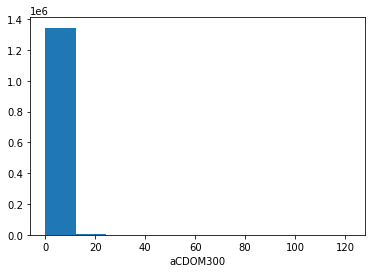

In [32]:
#here we can look at the histograms of the data 
combined_a.aCDOM300.plot.hist() 
#combined_a.aCDOM355.plot.hist()
#combined_a.S_275_295.plot.hist()
#combined_a.DOC.plot.hist()
#combined_a.Rrs_667.plot.hist()

In [33]:
combined_a.mean() 
#values of S_275_295 should be between .02 and .045 
#but here the mean is 0.5242 
#since DOC is mesured by aCDOM300 and S_275_295 DOC will be messed up two 
#aCDOM300 looks fine so the issues root is at S_275_295

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<xarray.Dataset>
Dimensions:      ()
Data variables: (12/16)
    Rrs_412      float32 0.004231
    Rrs_443      float32 0.004205
    Rrs_469      float32 0.00476
    Rrs_488      float32 0.00521
    Rrs_531      float32 0.005622
    Rrs_547      float32 0.005607
    ...           ...
    aCDOM300     float32 2.744
    aCDOM355     float32 0.8715
    lnS_275_295  float32 -0.6931
    S_275_295    float32 0.5286
    aCDOM_star   float32 1.152e-11
    DOC          float32 inf

In [13]:
combined_a.min()

<xarray.Dataset>
Dimensions:      ()
Data variables: (12/16)
    Rrs_412      float32 2e-06
    Rrs_443      float32 2e-06
    Rrs_469      float32 2e-06
    Rrs_488      float32 0.000286
    Rrs_531      float32 0.00023
    Rrs_547      float32 5e-05
    ...           ...
    aCDOM300     float32 0.009336
    aCDOM355     float32 0.00205
    lnS_275_295  float32 -1.721
    S_275_295    float32 0.1789
    aCDOM_star   float32 2.522e-44
    DOC          float32 1.573e+09

In [14]:
combined_a.max()

<xarray.Dataset>
Dimensions:      ()
Data variables: (12/16)
    Rrs_412      float32 0.02397
    Rrs_443      float32 0.02278
    Rrs_469      float32 0.02343
    Rrs_488      float32 0.02426
    Rrs_531      float32 0.02748
    Rrs_547      float32 0.02802
    ...           ...
    aCDOM300     float32 121.9
    aCDOM355     float32 10.79
    lnS_275_295  float32 0.9215
    S_275_295    float32 2.513
    aCDOM_star   float32 2.421e-09
    DOC          float32 inf

In [171]:
# since DOC should be in the 80 to 500 range we need a good est of S_275_295 
    # DOC = aCDOM300/aCDOM_star
    # aCDOM_star = np.exp(-15.05 - (33.95 * S_275_295)) + np.exp(-1.502 - (104.3 * S_275_295))
2.694 / np.exp(-1.502 - 104.3 * .025) + np.exp(-15.05 - 33.95 * 0.025)

164.10838254890902

In [21]:
#we need something like S_275_295 = .025
np.exp(-1.502 - 104.3 * .025) + np.exp(-15.05 - 33.95 * 0.025)

0.016416104991032306

In [20]:
# currently S_275_295 = .5 
# and gives us a way to small aCDOM_star
np.exp(-1.502 - 104.3 * .5) + np.exp(-15.05 - 33.95 * .5)

1.2351486192602234e-14

In [31]:
# the value we have before the exp should be in range to get a good output 
# S_275_295 = np.exp(lnS_275_295)
#lnS_275_295 should be between -4 and -3 
np.exp(-4) # 0.01831563888873418
np.exp(-3) # 0.049787068367863944

0.049787068367863944

(array([3.22290e+04, 1.26417e+05, 1.95615e+05, 1.96060e+05, 5.78271e+05,
        1.75501e+05, 6.71800e+03, 1.13800e+03, 9.20000e+01, 1.50000e+01]),
 array([-1.7208521 , -1.4566162 , -1.1923803 , -0.92814434, -0.6639084 ,
        -0.3996725 , -0.13543658,  0.12879935,  0.39303526,  0.6572712 ,
         0.9215071 ], dtype=float32),
 <BarContainer object of 10 artists>)

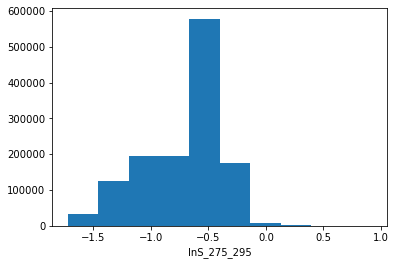

In [15]:
# however, the mean of our lnS_275_295 is -0.7 a min of -1.721 and a max of 0.9215
# and we can see in the hist 
combined_a.lnS_275_295.plot.hist()

In [16]:
#from the equation in our alg 
#lnS_275_295 = (alpha0 * np.log(ds.Rrs_443) +
#                  beta0 * np.log(ds.Rrs_488) +
#                  gamma0 * np.log(ds.Rrs_531) +
#                  delta0 * np.log(ds.Rrs_555) +
#                  epsilon0 * np.log(ds.Rrs_667) + zeta0)

#lnS_275_295 needs to a reasonabel sum of the Rrs values times there constnts 

alpha0 = -.0537
beta0 = -.2689
gamma0 = .1017
delta0 = -.2097
epsilon0 = -.0893
zeta0 = -3.6853
    
x = (alpha0 * np.log(0.004243) +
     beta0 * np.log(0.005299) +
     gamma0 * np.log(0.00571) +
     delta0 * np.log(0.005379) +
     epsilon0 * np.log(0.002607) + zeta0)

#when we look at the avages of the inputs we sill have a bad est of lnS_275_295

print(x)

#the strage thing is that the same Rrs inpusts had good outputs for the aCDOM values 

-0.8811690513654926


In [17]:
#the logs come out negative each time 
np.log(0.004243)

-5.462484712761949

In [18]:
#and since a negative * negative makes a positive, these values are positive 
np.log(0.004243)

-5.462484712761949

In [19]:
alpha0 * np.log(0.004243)

0.2933354290753166

In [20]:
beta0 * np.log(0.005299) 

1.4090997711062894

In [147]:
gamma0 * np.log(0.00571) 

-0.5253350371654559

In [148]:
delta0 * np.log(0.005379) 

1.0957355112564093

In [21]:
epsilon0 * np.log(0.002607)

0.531295274361948

In [43]:
#lnS_275_295 should be between -4 and -3 
# and the zeta0 = -3.6853 
# so the term without zeta0 should be 

alpha0 = -.0537
beta0 = -.2689
gamma0 = .1017
delta0 = -.2097
epsilon0 = -.0893
zeta0 = -3.6853

y = -3.5 -(zeta0)
    
x = (alpha0 * np.log(0.004243) +
     beta0 * np.log(0.005299) +
     gamma0 * np.log(0.00571) +
     delta0 * np.log(0.005379) +
     epsilon0 * np.log(0.002607))
print("we need the sums to be around")
print(y)
print("yet, the sums are around")
print(x)

we need the sums to be around
0.1852999999999998
yet, the sums are around
2.804130948634507


In [47]:
alpha0 = -.0537
beta0 = -.2689
gamma0 = .1017
delta0 = -.2097
epsilon0 = -.0893
zeta0 = -3.6853
    
x = (alpha0 * np.log(0.004243) +
     beta0 * np.log(0.005299) +
     gamma0 * np.log(0.00571) +
     delta0 * np.log(0.005379) +
     epsilon0 * np.log(0.002607) + zeta0)
x

-0.8811690513654926

In [ ]:
from sympy import symbols, Eq, solve

y = symbols('y')
eq1 = (alpha0 * np.log(y) +
       beta0 * np.log(0.005299) +
       gamma0 * np.log(0.00571) +
       delta0 * np.log(0.005379) +
       epsilon0 * np.log(0.002607)) + zeta0 


sol = solve(eq1)
sol[-3.5]

In [ ]:
y = symbols('y')
eq1 = (alpha0 * np.log(0.004243) +
       beta0 * np.log(y) +
       gamma0 * np.log(0.00571) +
       delta0 * np.log(0.005379) +
       epsilon0 * np.log(0.002607)) + zeta0 


sol = solve(eq1)
sol[-3.5]

In [ ]:
y = symbols('y')
eq1 = (alpha0 * np.log(0.004243) +
       beta0 * np.log(0.005299) +
       gamma0 * np.log(y) +
       delta0 * np.log(0.005379) +
       epsilon0 * np.log(0.002607)) + zeta0 


sol = solve(eq1)
sol[-3.5]

In [ ]:
y = symbols('y')
eq1 = (alpha0 * np.log(0.004243) +
       beta0 * np.log(0.005299) +
       gamma0 * np.log(0.00571) +
       delta0 * np.log(y) +
       epsilon0 * np.log(0.002607)) + zeta0 


sol = solve(eq1)
sol[-3.5]

In [ ]:
y = symbols('y')
eq1 = (alpha0 * np.log(0.004243) +
       beta0 * np.log(0.005299) +
       gamma0 * np.log(0.00571) +
       delta0 * np.log(0.005379) +
       epsilon0 * np.log(y)) + zeta0 


sol = solve(eq1)
sol[-3.5]

In [ ]:
# Looping through times to plot:


#Need to define GOOD min and max values for colorbar so it is the same for all figures
vmin = 0
# vmax = combined.Rrs_443.max()*10e2 #should probably set to a fix number so all different periods have the same color range
vmax = 5 # FIND A SENSIBLE VALUE FOR VMAX

# arguments for the colorbar
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':30, 'label':'Rrs 443 nm (x 10$^{-2}$ sr$^{-1}$)', 'pad': .01}
# Map projection
map_proj = ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0)

# looping through time dim
for i in range(combined.time.size):
    fig = plt.figure(dpi=200) # set fig size
    ax = fig.add_subplot(111, projection=map_proj)
    plot_mapbase(ax=ax)
    data = combined.aCDOM.isel(time=i) # <<<<< CHANGE THIS FOR PLOTING OTHER VARIABLES
    label = '/home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_{}_.png'.format(str(data.time.values)[:10]) # <<<<< CHANGE NAME IN LABEL 
    print(i, label)
    sat = (10e2*data.where(data>0)).plot(x='lon', y='lat',
                         transform=ccrs.PlateCarree(),
                         cmap='pink_r', vmin=vmin, vmax=vmax,
                         cbar_kwargs=cbar_kwargs,
                         robust=False,
                         ax=ax
                        )
    

    fig.savefig(label)
    plt.close(fig)

/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Returning aCDOM(lambda), SS_275_295 and DOC for lambda 300
aCDOM(300): CDOM absorption spectra (m-1)
SS_275_295: CDOM absorption spectral slope coefficient in the 275–295 nm spectral region (nm-1)
DOC: Disolved organic carbon (umol L-1)
according to Cao et. al 2018
0 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-10_.png
1 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-27_.png
2 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-30_.png
3 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-26_.png
4 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-11_.png
5 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-15_.png
6 /home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_2010-09-12_.png
7 /home/hboi-ouri/Projects/NASA_Pr